In [63]:
# Rainfall Forecasting Notebook

# this notebook aims to forecast rainfall as a supplematery data to eventually
# predict crop yield prediction. The inital plan was to forecast daily rainfall, but 
# due to limitation of dataset ( unbalanced distritution of the rainfall throughout  20 years)
# and Varuna's requirments that they desire to forecast throughout the year to cover all crop life cycles,
# this foreacsting needs to be adjusted to be weekly instead. Unless Varuna's requirements are adjusted, Weekly data seems
# to be the best option for their needs. Therefore, the implementation performs 50 weeks forecasting further instead.

# Dataset: retrieved from Nasa API as a .csv file. The source can also be obtained from Mr. Tranid, a senior GIS engineer at Varuna.
# Dataset characteristics:
#       1. 20 years Chaiyaphumi weather dataset
#       2. Weekly indexed rainfall value
#       3. training set: 2000-01-09 to 2020-09-13
#       4. testing set: 2020-09-20 to 2021-09-10
#       5. number of lags = 70
#
#Machine Learning Model:
#       Neural Prophet


# Author: Khanin Udomchoksakul ( Pao )
# Team: Bedrock
# Stakholder: Varuna
# Date Initated: 8/2021 - 11/2021


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
from datetime import datetime
date_format = "%Y-%m-%d"

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
from pandas import DataFrame

from pandas import read_csv
# normalize
from sklearn.preprocessing import MinMaxScaler
from neuralprophet import NeuralProphet, set_log_level
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import r2_score


Helper functions

In [64]:


#set date as index
def set_date_index(data):
    data.set_index('DATE', inplace=True)
    print(data)
    data.columns


def train_test_split(data):
    # manually specify what date range to train 
    # or test for your liking
    start_date_test = pd.to_datetime('2020-09-22')
    end_date_test = pd.to_datetime('2021-09-10')
    
    start_date_test_str = start_date_test.strftime("%Y-%m-%d")
    end_date_test_str = end_date_test.strftime("%Y-%m-%d")
    data_test = data[start_date_test_str: end_date_test_str]

    start_date = pd.to_datetime('2000-01-01')
    end_date = pd.to_datetime('2020-09-15')
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    data = data[start_date_str: end_date_str]
    
    return data_test, data

def from_daily_to_weekly(data):
    data['DATE'] = pd.to_datetime(data['DATE'])
    data = data.set_index(pd.DatetimeIndex(data['DATE']))
    # set each indexed value to weekly
    weekly_data = data.resample('W', on='DATE').mean()
    return weekly_data
    
#reassign negative values ( noise ) to be 0
def make_noise_0(forecast_diag):

    forecasted_rain = []
    for x in forecast_diag.values:
        
        x = float(x)
        #print(x)
        if x <0:
            print('less than 0')
            forecasted_rain.append(0)
            continue
        forecasted_rain.append(x)
    return forecasted_rain

Read Forecast Data 

In [65]:
data = read_csv('forecast_dataset.csv', header=0)
data.columns


Index(['DATE', 'T2M_MAX', 'T2M_MIN', 'T2M', 'PRECTOTCORR', 'TS_MAX', 'TS_MIN',
       'TS', 'RH2M', 'T2MDEW', 'PS', 'WS2M', 'ALLSKY_SFC_SW_DWN', 'GWETPROF'],
      dtype='object')

In [66]:
# Visualize dataframe for each category
data



,DATE,T2M_MAX,T2M_MIN,T2M,PRECTOTCORR,TS_MAX,TS_MIN,TS,RH2M,T2MDEW,PS,WS2M,ALLSKY_SFC_SW_DWN,GWETPROF
0,2000-01-01,29.83,15.91,22.16,0.00,33.00,15.33,22.58,72.25,16.33,97.01,2.34,4.97,0.55
1,2000-01-02,29.51,16.41,22.35,0.00,33.24,15.98,22.94,73.25,16.87,97.04,2.45,5.13,0.55
2,2000-01-03,30.33,16.95,22.94,0.00,34.48,16.58,23.66,73.50,17.40,96.97,2.02,4.84,0.55
3,2000-01-04,31.09,17.12,23.46,0.00,35.48,16.64,24.01,71.44,17.33,96.92,1.63,5.01,0.55
4,2000-01-05,32.33,17.67,25.03,0.00,37.14,15.80,24.38,58.62,15.30,96.93,0.99,4.98,0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7919,2021-09-06,27.23,22.65,24.78,28.46,28.00,22.19,24.83,92.19,23.38,96.79,1.03,3.84,-999.00
7920,2021-09-07,28.37,23.41,25.47,7.64,29.08,23.00,25.34,91.50,23.93,96.69,1.62,5.19,-999.00
7921,2021-09-08,28.49,23.25,25.67,9.13,29.58,22.90,25.51,88.00,23.48,96.44,1.00,1.95,-999.00
7922,2021-09-09,26.62,23.13,24.57,185.03,27.34,22.76,24.50,93.94,23.50,96.39,1.62,4.11,-999.00


In [67]:
# transforming daily data to weekly data here
weekly_data = from_daily_to_weekly(data)
#visualize the weekly dataframe
print(weekly_data)


              T2M_MAX    T2M_MIN        T2M  PRECTOTCORR     TS_MAX  \
DATE                                                                  
2000-01-02  29.670000  16.160000  22.255000     0.000000  33.120000   
2000-01-09  31.784286  18.621429  24.981429     0.107143  36.504286   
2000-01-16  33.182857  20.065714  26.081429     0.015714  38.440000   
2000-01-23  27.911429  15.614286  21.172857     0.261429  32.422857   
2000-01-30  27.760000  13.421429  19.988571     0.010000  32.084286   
...               ...        ...        ...          ...        ...   
2021-08-15  27.857143  23.434286  25.380000    10.248571  28.322857   
2021-08-22  29.628571  22.780000  26.001429     4.144286  30.845714   
2021-08-29  27.591429  22.974286  25.041429    18.254286  28.130000   
2021-09-05  27.675714  22.732857  24.848571    22.467143  28.560000   
2021-09-12  27.432000  23.092000  25.004000    53.570000  28.156000   

               TS_MIN         TS       RH2M     T2MDEW         PS      WS2M 

In [68]:
# Split the dataset
data_test, weekly_data = train_test_split(weekly_data)
# used for EDA but can be deleted 
data_corr = weekly_data[['PRECTOTCORR']]

EDA: Exploratory Data Analysis

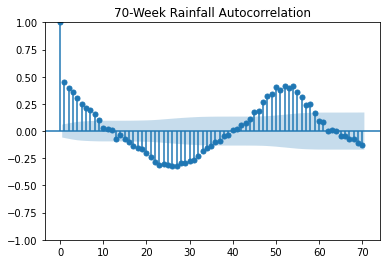

In [69]:
# Auto-Correlation Plot with 70 lags
acf_lpot = plot_acf(data_corr, lags = 70, title='70-Week Rainfall Autocorrelation')


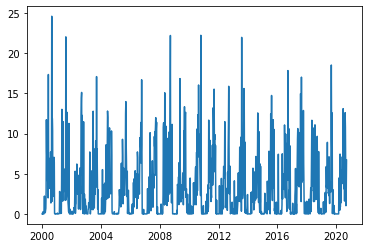

In [70]:
# Rainfall plot throughout the training set
pyplot.plot(weekly_data['PRECTOTCORR'])


<AxesSubplot:xlabel='PRECTOTCORR', ylabel='Count'>

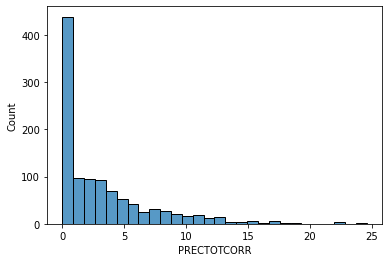

In [71]:
# Distribution Plot for training set
sns.histplot(weekly_data['PRECTOTCORR'])

In [72]:
# Set date index to 'ds' column to match neuralprophet format
weekly_data['ds'] = weekly_data.index
# assign for Pao's convention but can be changed 
data = weekly_data
data

,T2M_MAX,T2M_MIN,T2M,PRECTOTCORR,TS_MAX,TS_MIN,TS,RH2M,T2MDEW,PS,WS2M,ALLSKY_SFC_SW_DWN,GWETPROF,ds
DATE,,,,,,,,,,,,,,
2000-01-02,29.670000,16.160000,22.255000,0.000000,33.120000,15.655000,22.760000,72.750000,16.600000,97.025000,2.395000,5.050000,0.550000,2000-01-02
2000-01-09,31.784286,18.621429,24.981429,0.107143,36.504286,17.070000,24.972857,63.775714,16.848571,96.920000,1.147143,4.900000,0.541429,2000-01-09
2000-01-16,33.182857,20.065714,26.081429,0.015714,38.440000,18.270000,26.187143,57.482857,15.960000,96.842857,1.060000,5.085714,0.525714,2000-01-16
2000-01-23,27.911429,15.614286,21.172857,0.261429,32.422857,15.188571,21.871429,65.482857,13.765714,97.290000,2.534286,4.858571,0.520000,2000-01-23
2000-01-30,27.760000,13.421429,19.988571,0.010000,32.084286,13.245714,20.865714,60.928571,11.587143,97.520000,3.648571,5.111429,0.512857,2000-01-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-16,28.155714,22.731429,24.885714,10.781429,29.611429,22.392857,24.982857,89.205714,22.901429,96.647143,2.385714,4.785714,0.712857,2020-08-16
2020-08-23,28.510000,22.121429,25.115714,5.415714,29.757143,21.710000,25.185714,85.518571,22.370000,96.660000,1.760000,4.981429,0.730000,2020-08-23
2020-08-30,30.354286,22.962857,26.274286,1.020000,31.855714,22.530000,26.414286,84.928571,23.370000,96.561429,1.821429,6.202857,0.725714,2020-08-30


In [73]:
# drop any irrelevant data categories
data = data.drop(['T2M_MIN', 'RH2M', 'PS', 'RH2M', 'T2M_MAX','T2M', 'TS_MAX', 'TS_MIN', 'T2MDEW','TS', 'WS2M', 'GWETPROF','ALLSKY_SFC_SW_DWN' ], axis=1)
# rename rain to y to match neuralprophet format
data.rename(columns={'PRECTOTCORR':'y'},inplace=True)
df_train = data[['ds', 'y']]
df_train


,ds,y
DATE,,
2000-01-02,2000-01-02,0.000000
2000-01-09,2000-01-09,0.107143
2000-01-16,2000-01-16,0.015714
2000-01-23,2000-01-23,0.261429
2000-01-30,2000-01-30,0.010000
...,...,...
2020-08-16,2020-08-16,10.781429
2020-08-23,2020-08-23,5.415714
2020-08-30,2020-08-30,1.020000


Neural Prohpet Model configuration

In [74]:
m = NeuralProphet(
    n_changepoints=0,
    n_forecasts=50, # specify how much further forecast to perform
    n_lags = 70, # specify how many lags to use
    yearly_seasonality=True, # toggle yearly_seasonality
    epochs = 400,
    #learning_rate = 1
    #num_hidden_layers = 4
    # num_hidden_layers=1,
    # d_hidden=145,
    
)
# train the model: freq='W' means training with weekly data
# specify validation portion ( 20% in this case )
metrics = m.fit(df_train,validate_each_epoch=True, freq='W', valid_p=0.2)


INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16


  0%|          | 0/243 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.83E-03, min: 3.51E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 9.45E-02
Epoch[400/400]: 100%|██████████| 400/400 [00:24<00:00, 16.49it/s, SmoothL1Loss=0.0275, MAE=1.83, MSE=7.36, RegLoss=0, MAE_val=2.03, MSE_val=8.68, SmoothL1Loss_val=0.033]


     SmoothL1Loss        MAE         MSE  RegLoss  SmoothL1Loss_val   MAE_val  \
0        0.505798  10.230209  162.623067      0.0          0.403051  8.875162   
1        0.320370   7.763521   92.207992      0.0          0.286382  7.285886   
2        0.250178   6.763568   69.419887      0.0          0.235429  6.542894   
3        0.208892   6.136371   57.019946      0.0          0.201604  6.015695   
4        0.179070   5.641031   48.452538      0.0          0.173823  5.548749   
..            ...        ...         ...      ...               ...       ...   
395      0.027559   1.827828    7.369257      0.0          0.033005  2.025461   
396      0.027549   1.827533    7.366304      0.0          0.033002  2.025992   
397      0.027542   1.827394    7.364343      0.0          0.033010  2.026105   
398      0.027537   1.827148    7.363093      0.0          0.033009  2.026088   
399      0.027535   1.827061    7.362384      0.0          0.033009  2.026016   

        MSE_val  
0    122.

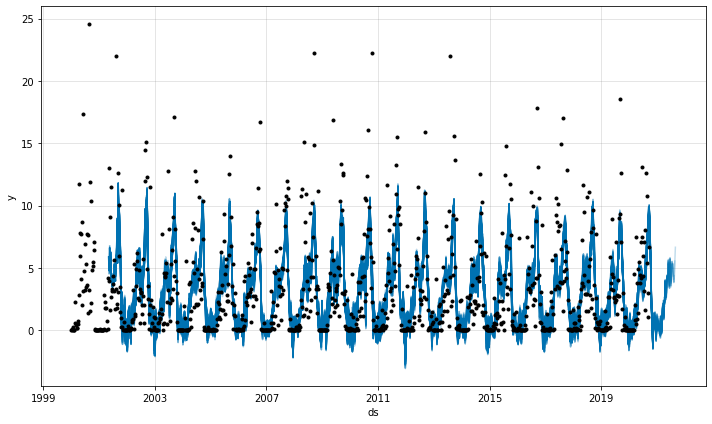

In [75]:

print(metrics)
#make further date dataframe for model prediction: 50 weeks further
#n_historic_predictions = use training set to forecast as well
future = m.make_future_dataframe(df_train, periods=50, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)


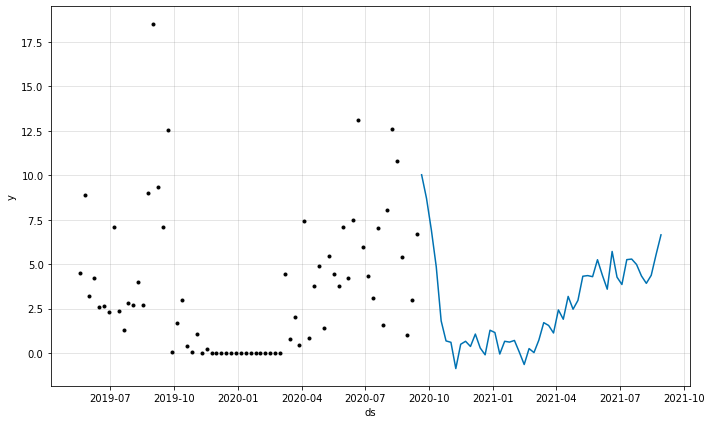

In [76]:
# focus only on prediction graph by using 
#highlight_nth_step_ahead_of_each_forecast

m = m.highlight_nth_step_ahead_of_each_forecast(None) # reset highlight
fig = m.plot_last_forecast(forecast)



In [77]:
# visualize forecast dataframe
# notice the structure is different from normal prophet
forecast[1080:]

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,ar43,ar44,ar45,ar46,ar47,ar48,ar49,ar50,trend,season_yearly
1080,2020-09-13,6.691429,9.192481,2.501052,9.420767,2.729338,9.220484,2.529055,9.11126,2.419832,...,0.874272,0.914112,0.933463,1.313446,1.305236,1.317101,1.317096,1.420724,2.05995,6.285341
1081,2020-09-20,NaN,10.030566,NaN,9.921638,NaN,9.766033,NaN,9.514637,NaN,...,1.768883,1.948959,1.947057,1.959477,1.964132,2.011452,2.104819,2.142139,2.059853,5.720984
1082,2020-09-27,NaN,None,NaN,8.706009,NaN,8.680291,NaN,8.458359,NaN,...,1.672122,1.6923,1.685826,1.71688,1.736984,2.077351,2.101076,2.309494,2.059755,4.457224
1083,2020-10-04,NaN,None,NaN,None,NaN,6.917274,NaN,6.843667,NaN,...,1.92339,1.894067,1.879533,2.232929,2.224512,2.222951,2.243196,2.346491,2.059658,2.768054
1084,2020-10-11,NaN,None,NaN,None,NaN,None,NaN,4.849461,NaN,...,2.623932,2.576222,2.608237,2.676741,2.624699,2.688657,2.758129,2.67948,2.05956,1.045308
1085,2020-10-18,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,0.774889,0.656529,0.642003,0.595098,0.581599,0.869344,0.922898,0.97468,2.059463,-0.345138
1086,2020-10-25,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,0.18852,0.182692,0.201407,0.213486,0.201877,0.239266,0.235279,0.278671,2.059365,-1.193653
1087,2020-11-01,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,-0.81333,-0.973682,-0.964975,-1.137525,-1.171274,-1.226906,-1.21472,-1.265702,2.059267,-1.508247
1088,2020-11-08,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,-1.974733,-1.941097,-1.951149,-1.882134,-1.89509,-1.908229,-1.908392,-1.897096,2.05917,-1.483283
1089,2020-11-15,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,-0.014691,0.080054,0.076552,-0.103252,-0.179787,-0.321341,-0.33334,-0.285331,2.059072,-1.393723


In [78]:
# check only yhat values from the 1st forecast to the last 

forecast_val = forecast[['yhat1','yhat2', 'yhat3','yhat4', 'yhat5','yhat6', 'yhat7','yhat8' , 'yhat9','yhat10', 'yhat11','yhat12', 'yhat13','yhat14', 'yhat15','yhat16', 'yhat17','yhat18', 'yhat19','yhat20', 'yhat21','yhat22', 'yhat23','yhat24' , 'yhat25','yhat26', 'yhat27','yhat28', 'yhat29','yhat30', 'yhat31','yhat32','yhat33','yhat34', 'yhat35','yhat36', 'yhat37','yhat38', 'yhat39','yhat40' , 'yhat41','yhat42', 'yhat43','yhat44', 'yhat45','yhat46', 'yhat47','yhat48', 'yhat49','yhat50' ]][1081:]
print(forecast_val)

          yhat1     yhat2     yhat3     yhat4     yhat5     yhat6     yhat7  \
1081  10.030566  9.921638  9.766033  9.514637  9.399977  9.442469  9.271368   
1082       None  8.706009  8.680291  8.458359  8.646606  8.937903  8.994006   
1083       None      None  6.917274  6.843667  6.987462   6.93814  7.117662   
1084       None      None      None  4.849461  4.890401  4.830307  4.887053   
1085       None      None      None      None  1.813777  1.704984  1.901732   
1086       None      None      None      None      None  0.685211  0.759814   
1087       None      None      None      None      None      None   0.60767   
1088       None      None      None      None      None      None      None   
1089       None      None      None      None      None      None      None   
1090       None      None      None      None      None      None      None   
1091       None      None      None      None      None      None      None   
1092       None      None      None      None      N

In [79]:
# because the acutal forecasted values are located in diagonal indexes, 
# we run this command to obtain the forecasted values 
forecast_diag = pd.Series(np.diag(forecast_val), index=[forecast_val.index, forecast_val.columns])
forecast_diag

1081  yhat1     10.030566
1082  yhat2      8.706009
1083  yhat3      6.917274
1084  yhat4      4.849461
1085  yhat5      1.813777
1086  yhat6      0.685211
1087  yhat7       0.60767
1088  yhat8     -0.868701
1089  yhat9      0.498077
1090  yhat10     0.664617
1091  yhat11     0.373282
1092  yhat12     1.071108
1093  yhat13     0.286163
1094  yhat14    -0.095102
1095  yhat15     1.286646
1096  yhat16     1.157737
1097  yhat17    -0.052288
1098  yhat18     0.664719
1099  yhat19     0.619411
1100  yhat20     0.712174
1101  yhat21     0.054103
1102  yhat22    -0.640662
1103  yhat23     0.254113
1104  yhat24     0.028881
1105  yhat25     0.731172
1106  yhat26     1.712708
1107  yhat27     1.554704
1108  yhat28     1.131314
1109  yhat29     2.428829
1110  yhat30     1.904821
1111  yhat31     3.188375
1112  yhat32     2.468091
1113  yhat33     2.964838
1114  yhat34     4.323048
1115  yhat35     4.359537
1116  yhat36     4.298566
1117  yhat37     5.251926
1118  yhat38     4.381516
1119  yhat39

In [80]:
# make forecasted negative noises to 0
forecasted_rain = make_noise_0(forecast_diag)
print(forecasted_rain)

less than 0
less than 0
less than 0
less than 0
[10.030566215515137, 8.706008911132812, 6.917273998260498, 4.849461078643799, 1.8137766122817993, 0.6852112412452698, 0.6076697707176208, 0, 0.49807748198509216, 0.6646173596382141, 0.3732815682888031, 1.0711082220077515, 0.2861633002758026, 0, 1.286645531654358, 1.1577372550964355, 0, 0.6647192239761353, 0.6194106936454773, 0.7121736407279968, 0.054103411734104156, 0, 0.2541128396987915, 0.0288812518119812, 0.7311718463897705, 1.712707757949829, 1.5547038316726685, 1.1313139200210571, 2.428828716278076, 1.9048205614089966, 3.1883749961853027, 2.468090534210205, 2.9648375511169434, 4.323048114776611, 4.359536647796631, 4.2985663414001465, 5.251926422119141, 4.381516456604004, 3.5947365760803223, 5.716606616973877, 4.271858215332031, 3.858182668685913, 5.256584167480469, 5.2891950607299805, 4.983400344848633, 4.3412041664123535, 3.9236624240875244, 4.374619007110596, 5.546378135681152, 6.6508684158325195]


In [81]:
# use r2score
r2 = r2_score(data_test['PRECTOTCORR']['2020-09-20':'2021-09-05'].values, forecasted_rain)
print('r2 score for a model is', r2)

r2 score for a model is 0.21441997057722428


Check weekly cumulative rainfall

In [82]:

forecasted_rain_sum = cal_weekly_cumulative_rain(forecast_diag,is_testset = False )
    

139.78773910552263


Acutal VS Forecasted Plot

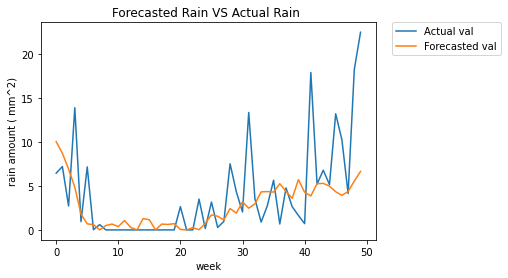

In [83]:


pyplot.plot(data_test['PRECTOTCORR']['2020-09-20':'2021-09-05'].values, label = 'Actual val')
pyplot.plot(forecasted_rain, label = 'Forecasted val')
plt.title('Forecasted Rain VS Actual Rain ')
plt.ylabel('rain amount ( mm^2)')
plt.xlabel('week')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [84]:
# Code that plans to check the forecasted value with the previous year
# No time to check this out but worth exploring for those continuing this

# idx = 0
# df_train_len = len(df_train)
# date_input = '2020-09-20'
# date_input_2 = '2019-09-20'
# for x in forecast['ds']:
#     #print(x)
#     #end_date_test = pd.to_datetime('2021-09-10')
    
#     x=x.strftime("%Y-%m-%d")
#     if x==date_input:
#         print('yes')
#         print(x)
#         print(idx)
#         forecast_idx = idx-df_train_len
#         forecasted
#         rain[forecast_idx]
#         print(forecasted_rain[forecast_idx])
#         print(forecast.iloc[idx])
    
#     idx+=1


Training Validation Check Plot

Text(0.5, 1.0, 'Model Loss (MSE)')

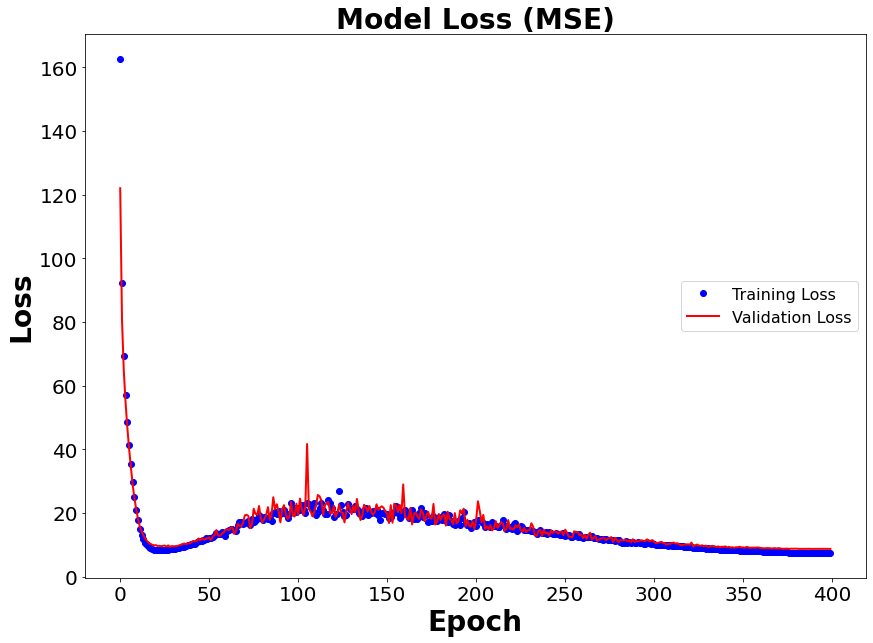

In [85]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(metrics["MSE"], 'ob', linewidth=6, label="Training Loss")  
ax.plot(metrics["MSE_val"], '-r', linewidth=2, label="Validation Loss")

# You can use metrics["SmoothL1Loss"] and metrics["SmoothL1Loss_val"] too.

ax.legend(loc='center right', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel("Epoch", fontsize=28, fontweight="bold")
ax.set_ylabel("Loss", fontsize=28, fontweight="bold")

ax.set_title("Model Loss (MSE)", fontsize=28, fontweight="bold")
#fig.savefig("model_loss_mae.png", **savefig_options)